In [1]:
import scanpy as sc
import anndata as ad
import numpy as np
import pandas as pd
import scvi
import os
import gc
import matplotlib.pyplot as plt

import sys
sys.path.append('/home/pab/projects/deepscore')
from deepscore import DeepScore
from peak_processing import *
from marker_analysis import *

%load_ext rpy2.ipython
scvi.settings.seed = 420
sc.settings.set_figure_params(dpi=80, color_map='gist_earth')

import warnings
warnings.filterwarnings('ignore')

Global seed set to 0
Global seed set to 420


In [2]:
%%R

library(Seurat)
library(Signac)
library(glue)
library(GenomicRanges)
set.seed(1234)
setwd("~/projects/kidney")
source("~/projects/utils/multiple_scataq_analysis.R")

R[write to console]: Attaching SeuratObject

R[write to console]: Loading required package: stats4

R[write to console]: Loading required package: BiocGenerics

R[write to console]: 
Attaching package: ‘BiocGenerics’


R[write to console]: The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


R[write to console]: The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min


R[write to console]: Loading required package: S4Vectors

R[write to console]: 
Attaching package: ‘S4Vectors’


R[write to console]: The following objects are masked from ‘package:base’:

    expand.gri

In [3]:
%%R

load("Atac/kidney.atac.RData")
load("Nuc/kidney.rna.RData")
load("Multi/kidney.multi.RData")

KeyboardInterrupt: 

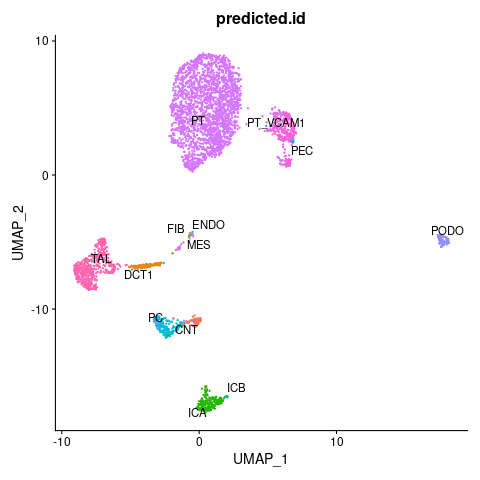

In [4]:
%%R 
DimPlot(kidney.rna, group.by = "predicted.id", label = T, repel = T) + NoLegend()

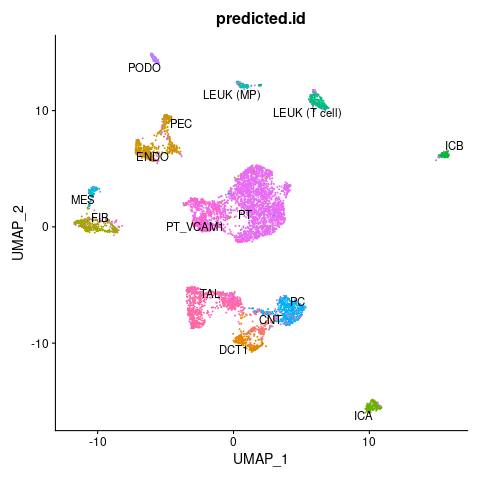

In [5]:
%%R 
DimPlot(kidney.atac, group.by = "predicted.id", label = T, repel = T) + NoLegend()

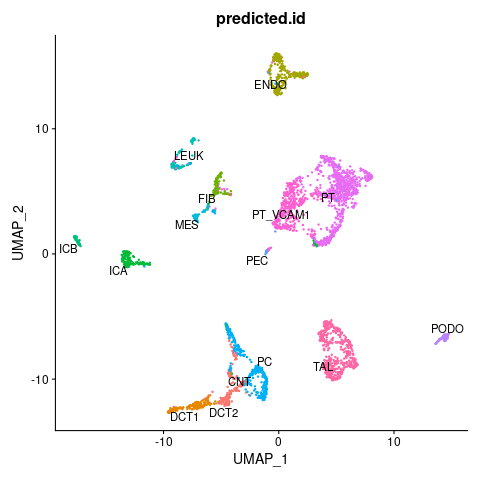

In [6]:
%%R
DimPlot(kidney.multi, group.by = "predicted.id", label = T, repel = T) + NoLegend()

In [7]:
%%R
print(kidney.atac)
print(kidney.rna)
print(kidney.multi)

An object of class Seurat 
169042 features across 5638 samples within 3 assays 
Active assay: peaks (148802 features, 148802 variable features)
 2 other assays present: RNA, chromvar
 2 dimensional reductions calculated: lsi, umap
An object of class Seurat 
20967 features across 3760 samples within 1 assay 
Active assay: RNA (20967 features, 800 variable features)
 2 dimensional reductions calculated: pca, umap
An object of class Seurat 
292582 features across 3243 samples within 6 assays 
Active assay: RNA (36601 features, 2000 variable features)
 5 other assays present: ATAC, peaks, SCT, chromvar, geneactivity
 3 dimensional reductions calculated: lsi, pca, umap


In [4]:
%%R

# Common set of peaks
DefaultAssay(kidney.atac) <- "peaks"
DefaultAssay(kidney.multi) <- "peaks"
peaks_atac <- granges(kidney.atac)
peaks_multi <- granges(kidney.multi)
combpeaks <- reduce(c(peaks_atac, peaks_multi))
combpeaks <- combpeaks[width(combpeaks) < 10000 & width(combpeaks) > 20]
combpeaks

GRanges object with 154136 ranges and 0 metadata columns:
           seqnames            ranges strand
              <Rle>         <IRanges>  <Rle>
       [1]     chr1     181368-181568      *
       [2]     chr1     778279-779235      *
       [3]     chr1     821554-821943      *
       [4]     chr1     827160-827643      *
       [5]     chr1     869566-870235      *
       ...      ...               ...    ...
  [154132]     chrY 22317087-22317744      *
  [154133]     chrY 22332927-22333146      *
  [154134]     chrY 22367437-22367637      *
  [154135]     chrY 22373340-22373857      *
  [154136]     chrY 26670292-26671714      *
  -------
  seqinfo: 24 sequences from an unspecified genome; no seqlengths


In [6]:
%%R

rm(kidney.rna, kidney.atac, kidney.multi)
gc()

             used   (Mb) gc trigger    (Mb)   max used    (Mb)
Ncells   11039168  589.6   22584805  1206.2   13426560   717.1
Vcells 1207137603 9209.8 2426150852 18510.1 2312947103 17646.4


In [ ]:
%%R

library(future)
plan("multiprocess", workers = 6)
options(future.globals.maxSize = 10000 * 1024^2)

sample.folders <- list(c("Atac", "kidney.atac.RData"),
                       c("Multi", "kidney.multi.RData"))

lapply(sample.folders, build_combined, combpeaks, drop_predictions = T)

In [ ]:
!Rscript ~/projects/utils/seurat2anndata.R Atac/kidney.atac_ds_combpeaks_all.RData peaks   # Atac
!Rscript ~/projects/utils/seurat2anndata.R Atac/kidney.atac.RData RNA                      # Atac Gene Activity
!Rscript ~/projects/utils/seurat2anndata.R Multi/kidney.multi_ds_combpeaks_all.RData peaks # Multi Atac
!Rscript ~/projects/utils/seurat2anndata.R Multi/kidney.multi.RData RNA                    # Multi RNA
!Rscript ~/projects/utils/seurat2anndata.R Nuc/kidney.rna.RData                            # RNA

### Now load and process the reference we will use to annotate:

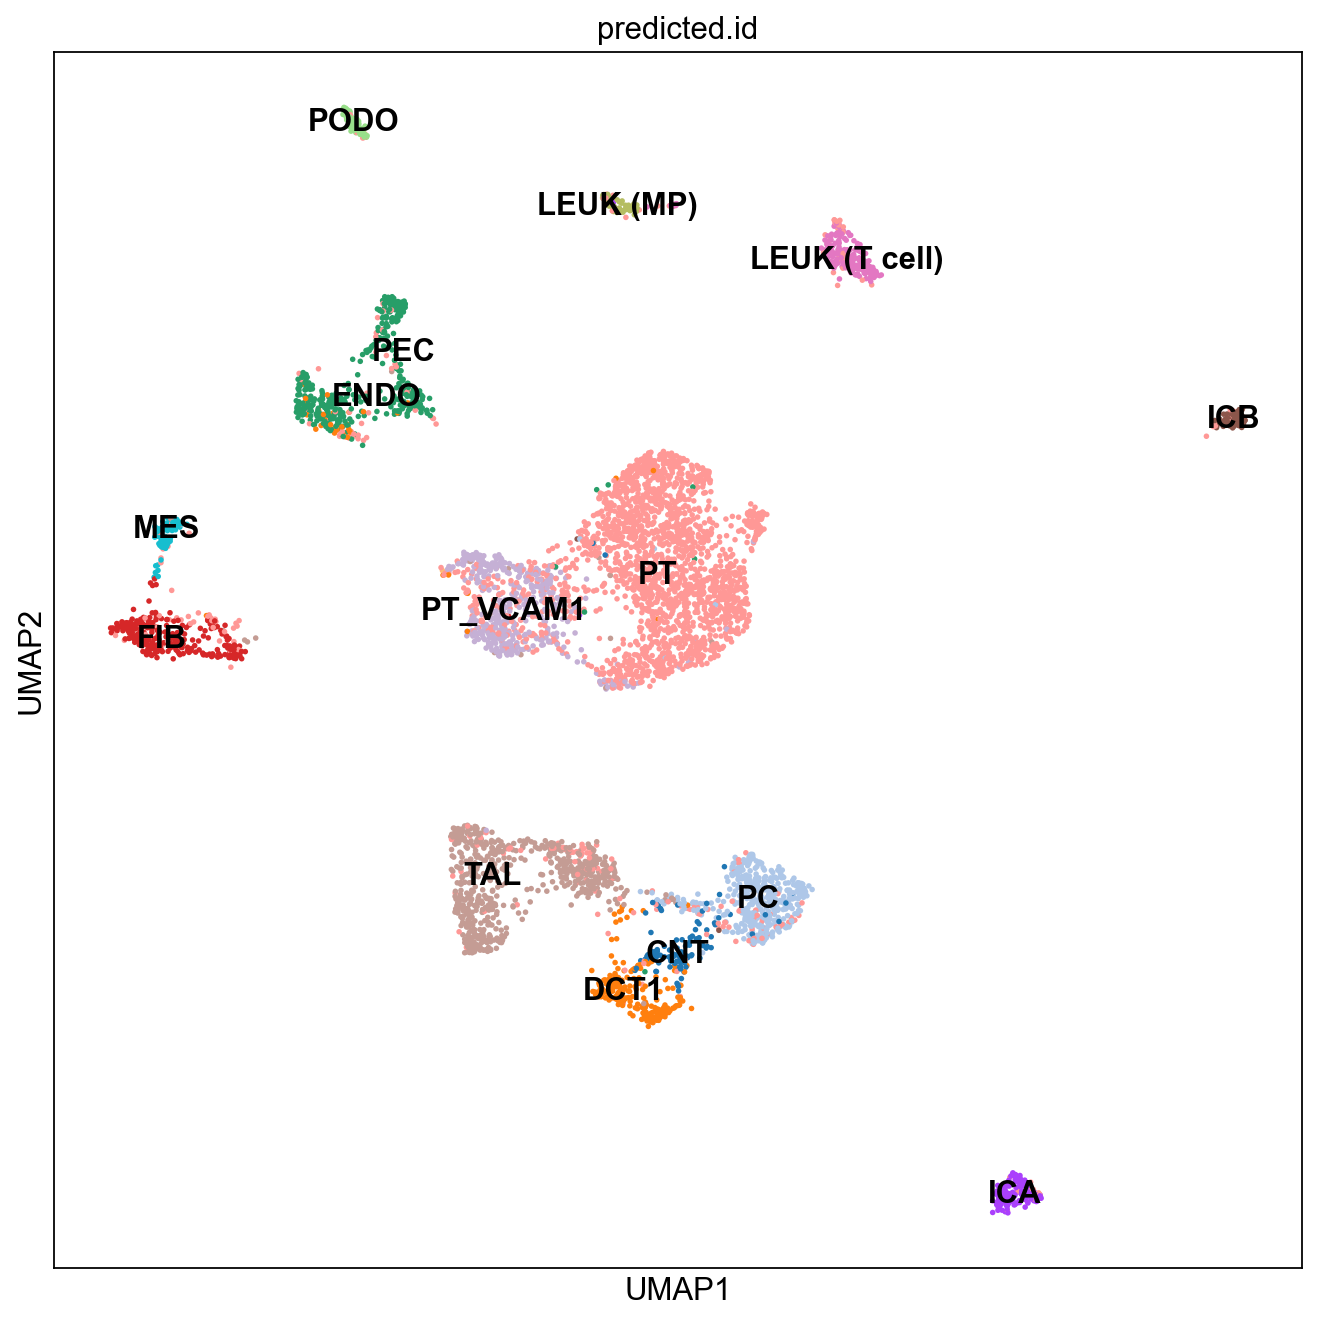

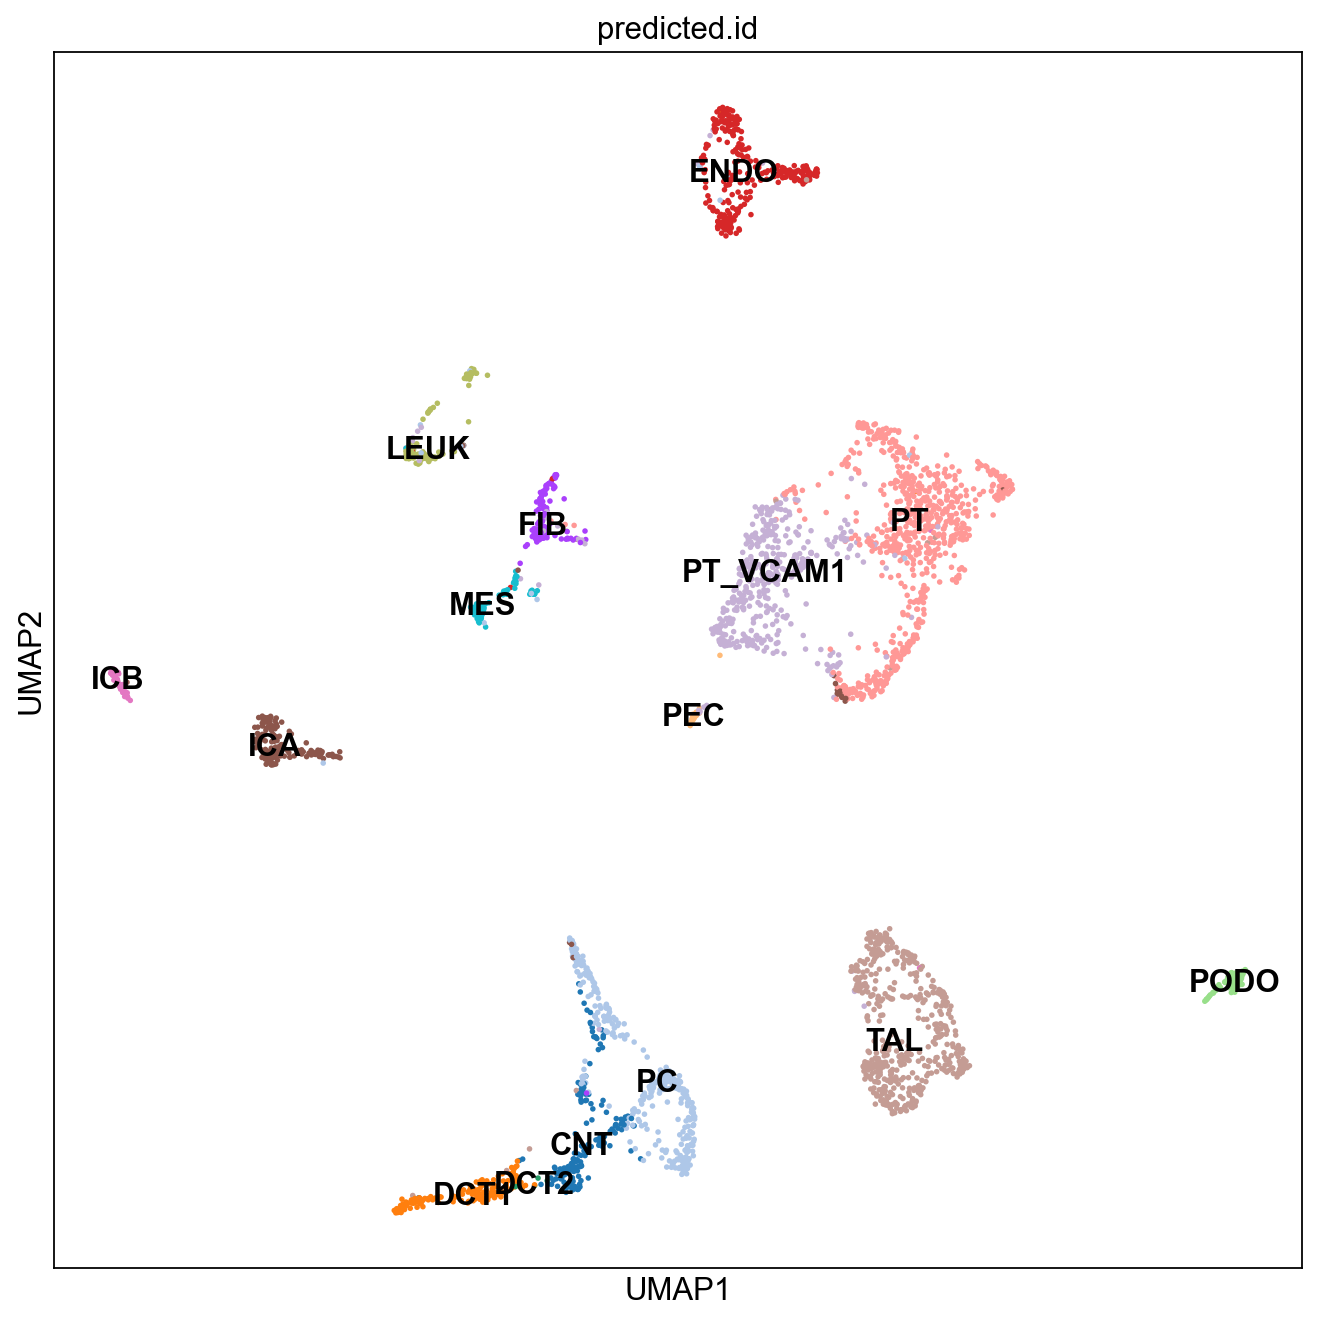

In [4]:
sc.settings.set_figure_params(figsize=('10', '10'), color_map='gist_earth')
# Load and process the reference

atac_peaks = sc.read_h5ad('Atac/kidney.atac_ds_combpeaks_all_peaks.h5ad')
atac_peaks.var_names_make_unique()
sc.pp.normalize_total(atac_peaks, target_sum=1e4)
sc.pp.log1p(atac_peaks)

atac_geneact = sc.read_h5ad('Atac/kidney.atac_RNA.h5ad')
atac_geneact.var_names_make_unique()
sc.pp.normalize_total(atac_geneact, target_sum=1e4)
sc.pp.log1p(atac_geneact)
sc.pl.umap(atac_geneact, color='predicted.id', legend_loc = 'on data', size = 25)

multi_peaks = sc.read_h5ad('Multi/kidney.multi_ds_combpeaks_all_peaks.h5ad')
multi_peaks.var_names_make_unique()
sc.pp.normalize_total(multi_peaks, target_sum=1e4)
sc.pp.log1p(multi_peaks)

multi_rna = sc.read_h5ad('Multi/kidney.multi_RNA.h5ad')
multi_rna.var_names_make_unique()
sc.pp.normalize_total(multi_rna, target_sum=1e4)
sc.pp.log1p(multi_rna)
sc.pl.umap(multi_rna, color='predicted.id', legend_loc = 'on data', size = 25)

In [9]:
sc.tl.rank_genes_groups(multi_rna, groupby="predicted.id")
top_markers(multi_rna)

,CNT,DCT1,DCT2,ENDO,FIB,ICA,ICB,LEUK,MES,PC,PEC,PODO,PT,PT_VCAM1,TAL
0,AC019197.1,MALAT1,ETNK1,PLPP1,RBMS3,CLNK,CA12,ARHGAP15,PRKG1,PDE10A,SYNE1,PLA2R1,ACSM2B,RHEX,SLC12A1
1,PDE4D,SLC12A3,AC019197.1,MEIS2,CALD1,ADGRF5,CA8,CELF2,RBMS3,MECOM,ALDH1A2,MAGI2,CUBN,PTPRD,ERBB4
2,MECOM,RNPC3,CCSER1,PTPRM,C7,PDE1C,SLC4A9,IKZF1,EBF1,CCSER1,LINC01435,PTPRO,ACSM2A,BNC2,CASR
3,PRKG1,ERBB4,AC138123.1,EMCN,NR2F2-AS1,PACRG,MAGI3,ANKRD44,PIP5K1B,PRKAG2,FRMD4A,PTPRQ,AC096577.1,ITGB8,CCSER1
4,ESRRG,FMN1,ESRRG,PTPRB,PRKG1,SLC26A7,ADAMTSL3,PTPRC,CALD1,ABTB2,FBXL7,COL4A3,PTH2R,UGT2B7,PLCB1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,CHPT1,PTPN4,CCDC198,PLPP3,LDLRAD4,AP000282.1,HPSE,SP140,PTEN,SH3BP5,PAG1,GRK5,ZNF804B,ABCC4,PPM1E
96,TBC1D9,TBC1D9,EFNA5,NCOA3,TANC1,CNTNAP5,PLCL1,PIK3R1,ARHGAP26,HOXB3,RBMS3,CERS6,LINC01515,LYPLAL1,CA12
97,NRCAM,AC040174.1,WSB1,PLAT,KIAA1211,PCNX4,BCO2,SLC4A7,TRPM3,FAM107B,ITIH5,CLIP4,GPX3,HAVCR1,WNK4
98,BABAM2,ELOVL7,ZNF704,PIP4K2A,PLA2G4A,UST,AL589693.1,SKAP1,EDIL3,NDRG1,PHLDB1,AC092813.2,RMST,MPP6,DANT2


# Using the multiome RNA and the gene activity inferred from ATAC

### Find common features between the two datasets and filter the others:

In [14]:
multi_rna, atac_geneact = find_common_genes(multi_rna, atac_geneact, target_n_genes=3000)

Dimensions before filtering: (3243, 36601) and (5638, 19607)

Looking for 5000 HVG
Found 1065 genes in common
Looking for 6000 HVG
Found 1418 genes in common
Looking for 7000 HVG
Found 1829 genes in common
Looking for 8000 HVG
Found 2320 genes in common
Looking for 9000 HVG
Found 2855 genes in common
Looking for 10000 HVG
Found 3444 genes in common
Filtering the data to these features and scaling

Dimensions after filtering: (3243, 3444) and (5638, 3444)


### Prepare the reference data and train model:

In [16]:
!rm -r logs/*
import imageio
import tensorflow as tf

def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

label_key = "predicted.id"
n_feat = multi_rna.shape[1]
n_labs = len(multi_rna.obs[label_key].cat.categories)
ds = DeepScore(hidden_nodes=[512, 128, 64], n_features=n_feat, 
               n_labels=n_labs, batch_size=32, dropout_rate=0.5, 
               epochs=30, weight_reg=True)

ds.set_reference(multi_rna, label_by=label_key , test_prop=0.2)
ds.train(earlystopping=False, lr_scheduler=scheduler,
         create_gif=True, gif_dataset=atac_geneact)
ds.model.save('rna_kidney')

rm: cannot remove 'logs/*': No such file or directory
Model: "deepscore"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_4 (Batch (None, 3444)              13776     
_________________________________________________________________
dense512 (Dense)             (None, 512)               1763840   
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 512)               2048      
_________________________________________________________________
dense128 (Dense)             (None, 128)               65664     
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
bat

2021-11-17 13:03:42.888984: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-11-17 13:03:42.889021: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-11-17 13:03:43.405413: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-11-17 13:03:43.406971: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed


Epoch 1/30
 1/73 [..............................] - ETA: 1:00 - loss: 3.5436 - categorical_accuracy: 0.0625

2021-11-17 13:03:44.336092: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-11-17 13:03:44.336113: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


15/73 [=====>........................] - ETA: 2s - loss: 3.2384 - categorical_accuracy: 0.0854 

2021-11-17 13:03:44.702408: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-11-17 13:03:44.703821: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2021-11-17 13:03:44.764749: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 289 callback api events and 286 activity events. 
2021-11-17 13:03:44.779563: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-11-17 13:03:44.800861: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./deepscore_logs/train/plugins/profile/2021_11_17_13_03_44

2021-11-17 13:03:44.813768: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./deepscore_logs/train/plugins/profile/2021_11_17_13_03_44/kino.trace.json.gz
2021-11-17 13:03:44.829616: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory:

73/73 [==============================] - 2s 13ms/step - loss: 2.5391 - categorical_accuracy: 0.2489 - val_loss: 1.0318 - val_categorical_accuracy: 0.8077


... storing 'Deepscore' as categorical


Epoch 2/30
73/73 [==============================] - 0s 4ms/step - loss: 1.4774 - categorical_accuracy: 0.5840 - val_loss: 0.6334 - val_categorical_accuracy: 0.8385


... storing 'Deepscore' as categorical


Epoch 3/30
73/73 [==============================] - 0s 4ms/step - loss: 1.1107 - categorical_accuracy: 0.6799 - val_loss: 0.4866 - val_categorical_accuracy: 0.8462


... storing 'Deepscore' as categorical


Epoch 4/30
73/73 [==============================] - 0s 4ms/step - loss: 0.9038 - categorical_accuracy: 0.7421 - val_loss: 0.4152 - val_categorical_accuracy: 0.8615


... storing 'Deepscore' as categorical


Epoch 5/30
73/73 [==============================] - 0s 4ms/step - loss: 0.7163 - categorical_accuracy: 0.7969 - val_loss: 0.4084 - val_categorical_accuracy: 0.8654


... storing 'Deepscore' as categorical


Epoch 6/30
73/73 [==============================] - 0s 4ms/step - loss: 0.6526 - categorical_accuracy: 0.8179 - val_loss: 0.3868 - val_categorical_accuracy: 0.8808


... storing 'Deepscore' as categorical


Epoch 7/30
73/73 [==============================] - 0s 4ms/step - loss: 0.5510 - categorical_accuracy: 0.8320 - val_loss: 0.3852 - val_categorical_accuracy: 0.8731


... storing 'Deepscore' as categorical


Epoch 8/30
73/73 [==============================] - 0s 4ms/step - loss: 0.4750 - categorical_accuracy: 0.8702 - val_loss: 0.3787 - val_categorical_accuracy: 0.8923


... storing 'Deepscore' as categorical


Epoch 9/30
73/73 [==============================] - 0s 4ms/step - loss: 0.4212 - categorical_accuracy: 0.8826 - val_loss: 0.3849 - val_categorical_accuracy: 0.8923


... storing 'Deepscore' as categorical


Epoch 10/30
73/73 [==============================] - 0s 4ms/step - loss: 0.3504 - categorical_accuracy: 0.9087 - val_loss: 0.3935 - val_categorical_accuracy: 0.8962


... storing 'Deepscore' as categorical


Epoch 11/30
73/73 [==============================] - 0s 4ms/step - loss: 0.3084 - categorical_accuracy: 0.9182 - val_loss: 0.4158 - val_categorical_accuracy: 0.8962


... storing 'Deepscore' as categorical


Epoch 12/30
73/73 [==============================] - 0s 4ms/step - loss: 0.2874 - categorical_accuracy: 0.9242 - val_loss: 0.4078 - val_categorical_accuracy: 0.8808


... storing 'Deepscore' as categorical


Epoch 13/30
73/73 [==============================] - 0s 4ms/step - loss: 0.2588 - categorical_accuracy: 0.9310 - val_loss: 0.4350 - val_categorical_accuracy: 0.8923


... storing 'Deepscore' as categorical


Epoch 14/30
73/73 [==============================] - 0s 4ms/step - loss: 0.2527 - categorical_accuracy: 0.9323 - val_loss: 0.4572 - val_categorical_accuracy: 0.8923


... storing 'Deepscore' as categorical


Epoch 15/30
73/73 [==============================] - 0s 4ms/step - loss: 0.2337 - categorical_accuracy: 0.9336 - val_loss: 0.4722 - val_categorical_accuracy: 0.8885


... storing 'Deepscore' as categorical


Epoch 16/30
73/73 [==============================] - 0s 4ms/step - loss: 0.2227 - categorical_accuracy: 0.9396 - val_loss: 0.4622 - val_categorical_accuracy: 0.8885


... storing 'Deepscore' as categorical


Epoch 17/30
73/73 [==============================] - 0s 4ms/step - loss: 0.2098 - categorical_accuracy: 0.9413 - val_loss: 0.4902 - val_categorical_accuracy: 0.8885


... storing 'Deepscore' as categorical


Epoch 18/30
73/73 [==============================] - 0s 4ms/step - loss: 0.1909 - categorical_accuracy: 0.9520 - val_loss: 0.5077 - val_categorical_accuracy: 0.8885


... storing 'Deepscore' as categorical


Epoch 19/30
73/73 [==============================] - 0s 4ms/step - loss: 0.1727 - categorical_accuracy: 0.9580 - val_loss: 0.5071 - val_categorical_accuracy: 0.8923


... storing 'Deepscore' as categorical


Epoch 20/30
73/73 [==============================] - 0s 4ms/step - loss: 0.1887 - categorical_accuracy: 0.9477 - val_loss: 0.4948 - val_categorical_accuracy: 0.8885


... storing 'Deepscore' as categorical


Epoch 21/30
73/73 [==============================] - 0s 4ms/step - loss: 0.1709 - categorical_accuracy: 0.9584 - val_loss: 0.5165 - val_categorical_accuracy: 0.8885


... storing 'Deepscore' as categorical


Epoch 22/30
73/73 [==============================] - 0s 4ms/step - loss: 0.1523 - categorical_accuracy: 0.9619 - val_loss: 0.5119 - val_categorical_accuracy: 0.8885


... storing 'Deepscore' as categorical


Epoch 23/30
73/73 [==============================] - 0s 4ms/step - loss: 0.1760 - categorical_accuracy: 0.9554 - val_loss: 0.5023 - val_categorical_accuracy: 0.8846


... storing 'Deepscore' as categorical


Epoch 24/30
73/73 [==============================] - 0s 4ms/step - loss: 0.1495 - categorical_accuracy: 0.9602 - val_loss: 0.5025 - val_categorical_accuracy: 0.8885


... storing 'Deepscore' as categorical


Epoch 25/30
73/73 [==============================] - 0s 4ms/step - loss: 0.1348 - categorical_accuracy: 0.9674 - val_loss: 0.5093 - val_categorical_accuracy: 0.8846


... storing 'Deepscore' as categorical


Epoch 26/30
73/73 [==============================] - 0s 4ms/step - loss: 0.1394 - categorical_accuracy: 0.9653 - val_loss: 0.5111 - val_categorical_accuracy: 0.8885


... storing 'Deepscore' as categorical


Epoch 27/30
73/73 [==============================] - 0s 4ms/step - loss: 0.1386 - categorical_accuracy: 0.9700 - val_loss: 0.5219 - val_categorical_accuracy: 0.8885


... storing 'Deepscore' as categorical


Epoch 28/30
73/73 [==============================] - 0s 4ms/step - loss: 0.1480 - categorical_accuracy: 0.9597 - val_loss: 0.5308 - val_categorical_accuracy: 0.8846


... storing 'Deepscore' as categorical


Epoch 29/30
73/73 [==============================] - 0s 4ms/step - loss: 0.1374 - categorical_accuracy: 0.9657 - val_loss: 0.5518 - val_categorical_accuracy: 0.8808


... storing 'Deepscore' as categorical


Epoch 30/30
73/73 [==============================] - 0s 4ms/step - loss: 0.1509 - categorical_accuracy: 0.9614 - val_loss: 0.5537 - val_categorical_accuracy: 0.8808


... storing 'Deepscore' as categorical


figures/umap_ds_training0.png
figures/umap_ds_training1.png
figures/umap_ds_training2.png
figures/umap_ds_training3.png
figures/umap_ds_training4.png
figures/umap_ds_training5.png
figures/umap_ds_training6.png
figures/umap_ds_training7.png
figures/umap_ds_training8.png
figures/umap_ds_training9.png
figures/umap_ds_training10.png
figures/umap_ds_training11.png
figures/umap_ds_training12.png
figures/umap_ds_training13.png
figures/umap_ds_training14.png
figures/umap_ds_training15.png
figures/umap_ds_training16.png
figures/umap_ds_training17.png
figures/umap_ds_training18.png
figures/umap_ds_training19.png
figures/umap_ds_training20.png
figures/umap_ds_training21.png
figures/umap_ds_training22.png
figures/umap_ds_training23.png
figures/umap_ds_training24.png
figures/umap_ds_training25.png
figures/umap_ds_training26.png
figures/umap_ds_training27.png
figures/umap_ds_training28.png
figures/umap_ds_training29.png

Evaluating model performance on unseen data (test data):

21/21 [==============

2021-11-17 13:04:30.468659: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: rna_kidney/assets


### Predict the celltypes in our sample using the trained model:

... storing 'Deepscore' as categorical


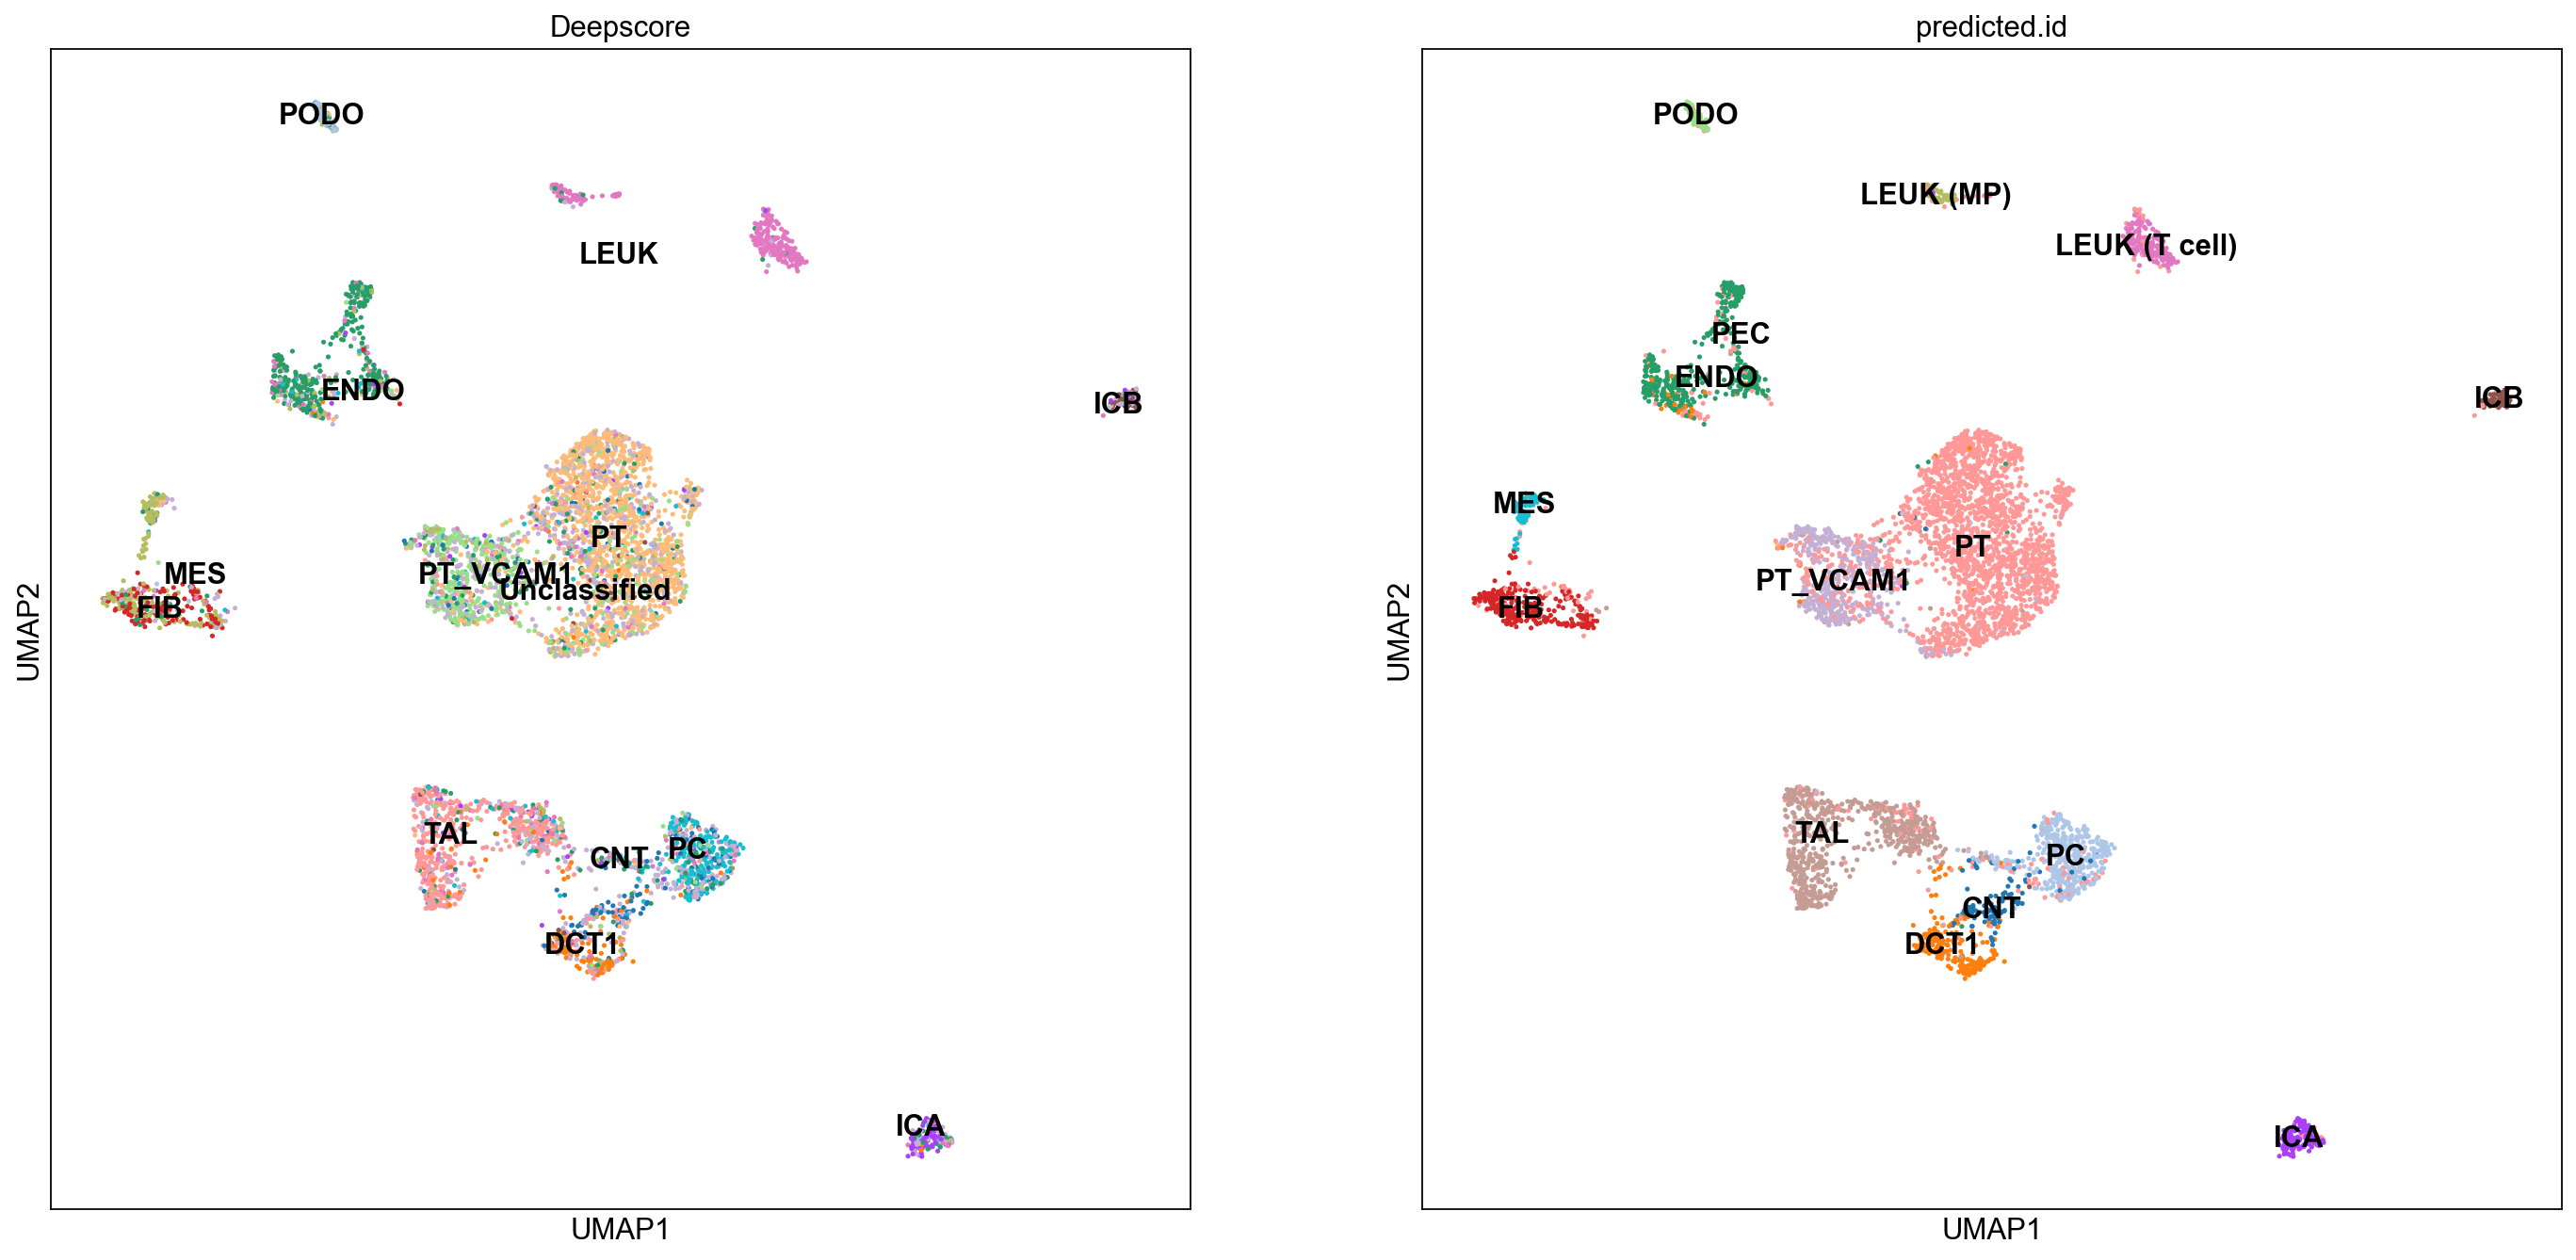

In [17]:
atac_geneact = ds.annotate(atac_geneact)
sc.pl.umap(atac_geneact, color=['Deepscore', 'predicted.id'], legend_loc='on data')

In [18]:
sc.tl.rank_genes_groups(multi_rna, 'predicted.id', method='logreg')
sc.tl.rank_genes_groups(atac_geneact, 'Deepscore', method='logreg')

In [19]:
ref_markers = top_markers(multi_rna, ntop=100)
sample_markers = top_markers(atac_geneact, ntop=100)
ref_markers.head(5), sample_markers.head(5)

(       CNT      DCT1     DCT2    ENDO       FIB       ICA      ICB    LEUK  \
 0    CALB1   SLC12A3    TRPM6  SHANK3        C7      CLNK   SLC4A9   IKZF1   
 1    SCN2A  ADAMTS17   LSMEM2    EMCN     SVEP1   SLC26A7  SLC26A4  PIK3R5   
 2     SOX5     SALL3  GPR137C    XAF1  CRISPLD2  MTRNR2L1      CA8   SMAP2   
 3  PIK3C2G     RNPC3  SLC12A3     TEK     ABCC9    ADGRF5    INSRR  TBXAS1   
 4    SYNPR   TMEM52B     EGR3   PLPP1     ABCA8     NXPH2     SACS   CXCR4   
 
         MES       PC    PEC    PODO        PT PT_VCAM1      TAL  
 0   COL25A1    GATA3    CFH   PTPRO  EBNA1BP2   KCTD16  SLC12A1  
 1     WFDC1    FXYD4  WSCD2   PTPRQ       PLG   DOCK11     CASR  
 2   PIP5K1B      TOX  KCNT2   NPHS1       AFM  COL27A1     SIM2  
 3  TMEM132C  ST6GAL1  EDIL3   NPHS2     PDZD2  RHOBTB1     UMOD  
 4     AGTR1   ATP1B3   OCA2  PLA2R1    SLC4A4   CAPN12      GP2  ,
       CNT     DCT1      ENDO    FIB    ICA       ICB   LEUK     MES       PC  \
 0  PKMYT1   PKMYT1     BLACE  GATA6  SY

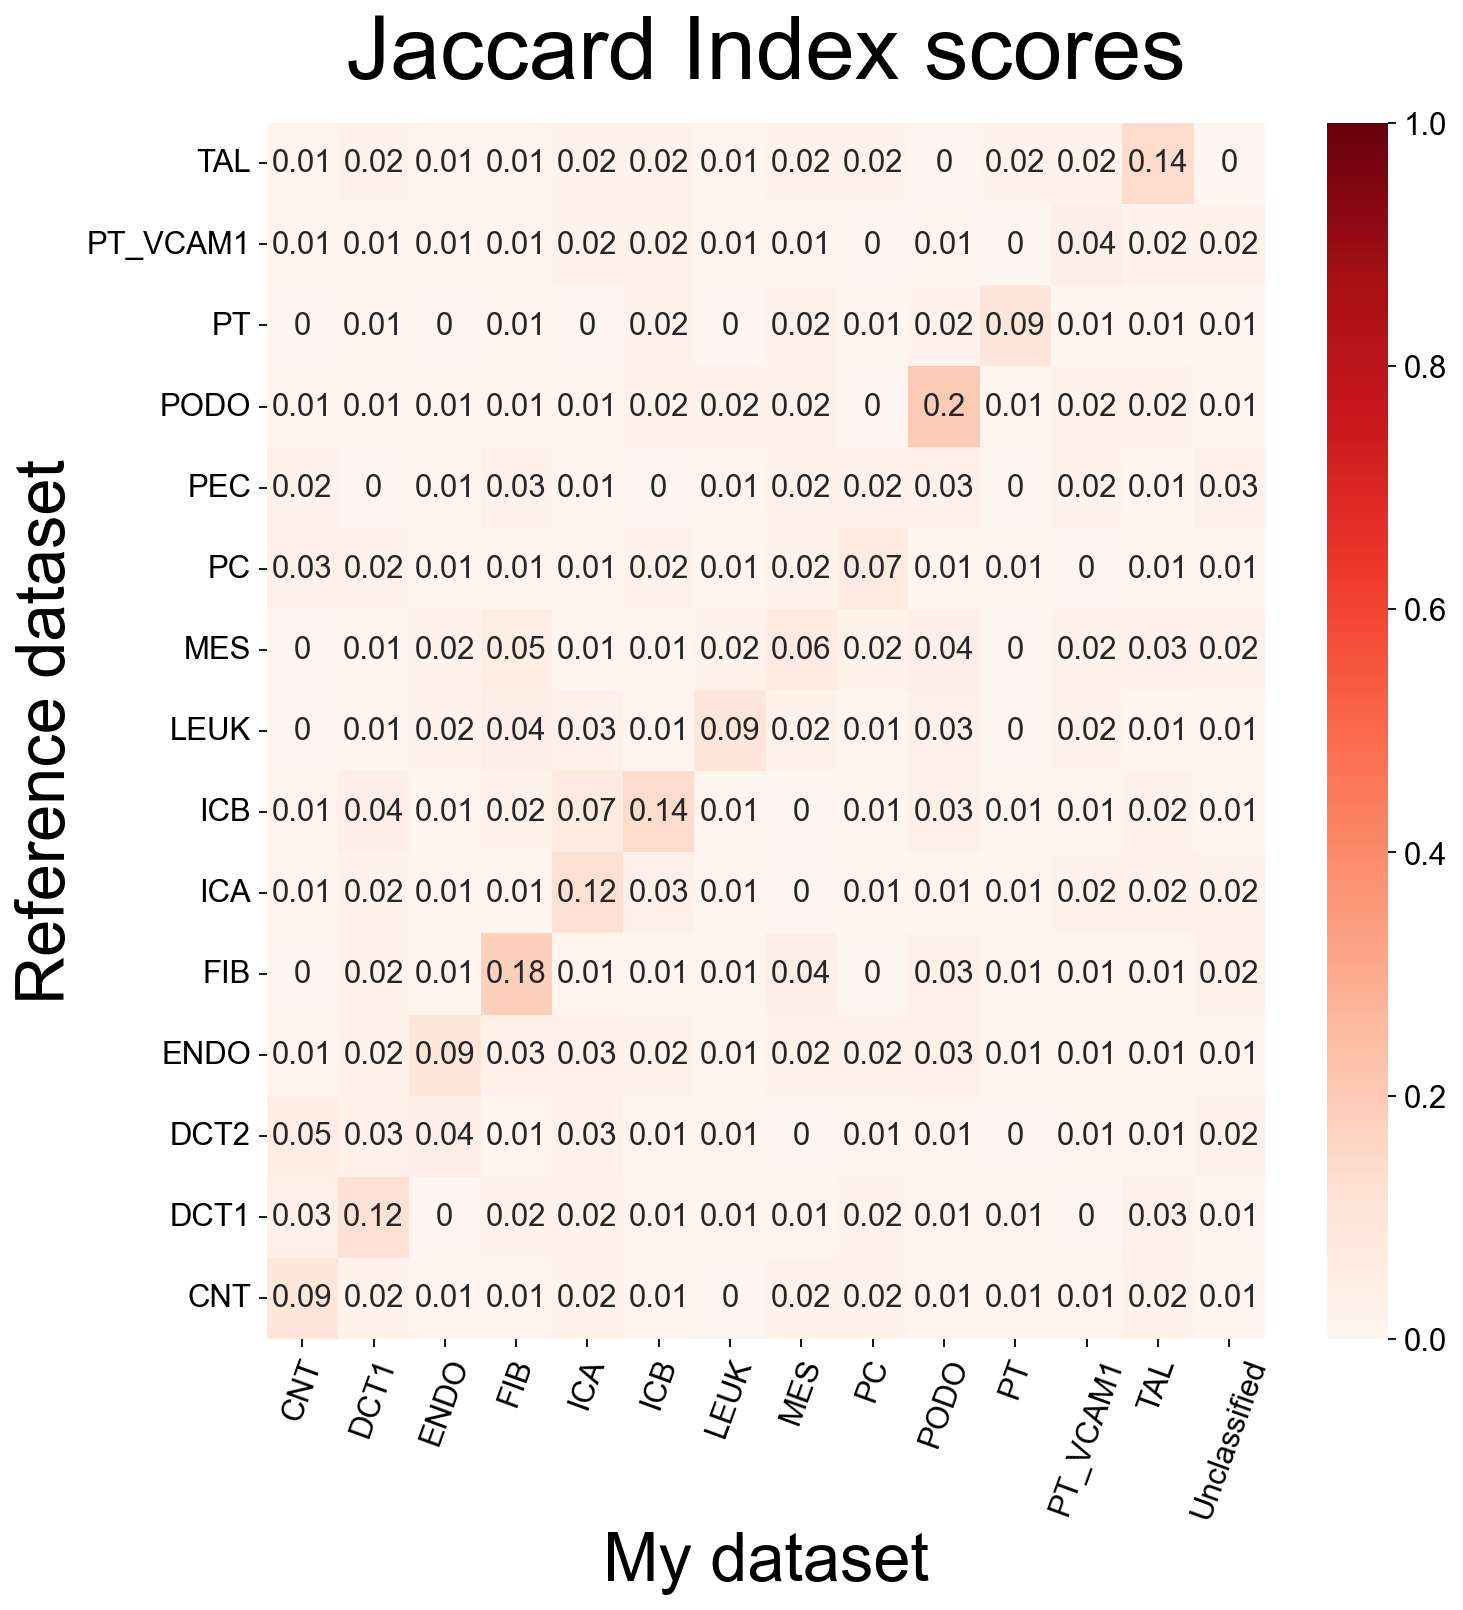

In [20]:
ms = matchscore(ref_markers, sample_markers, plot=True)

# Using the multiome peaks and the ATAC peaks